# Projekt: Bitcoin-Kurs vorhersagen

- Datenvorbereitung
- Prediktionsmodell basierend auf LSTM
    - input shape: (number_of_train_examples, sequence_length, input_dim)

Import der notwendigen Libraries

In [8]:
import numpy as np
import pandas as pd

Einlesen der BTC-Daten

In [9]:
# Load data without the first row as it may contain metadata
df = pd.read_csv("Kraken_BTCUSD_d.csv", header=1)
df.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,2018-08-11,BTCUSD,6141.5,6228.9,5969.6,6228.9,2586.37,15763120.05
1,2018-08-10,BTCUSD,6536.0,6579.1,6010.0,6141.5,7526.91,47487206.71
2,2018-08-09,BTCUSD,6275.9,6630.5,6179.1,6536.0,5942.17,38175637.90
3,2018-08-08,BTCUSD,6717.8,6717.8,6120.0,6275.9,9468.23,60523770.56
4,2018-08-07,BTCUSD,6935.7,7149.0,6659.9,6717.8,6505.50,45042696.31


## Vorverarbeitung der Daten
- Berechnung der Kursänderungen

In [10]:
# Calculate percentage changes in the 'Open' price
df["Open_before"] = df["Open"].shift(-1)
df["Open_changes"] = (df["Open"] / df["Open_before"]) - 1

df["High_before"] = df["High"].shift(-1)
df["High_changes"] = (df["High"] / df["High_before"]) - 1

# Remove rows with NaN values
df = df.dropna()

# Extract the changes columns as a NumPy array
changes = df[["Open_changes", "High_changes"]].values
#changes.head()

Aufbereitung der Daten: 
- die Vorhersage des nächsten Kurswertes soll auf den letzten 20 Werten basieren
- input shape: (number_of_train_examples, sequence_length, input_dim)
- Datenreihenfolge muss gedreht werden

In [11]:
# Prepare sequences of 20 changes to predict the next change
X = []
Y = []

# Create sequences
for i in range(0, len(changes) - 20):
    Y.append(changes[i,0])
    X.append(np.array(changes[i+1:i+21][::-1]))

# Reshape X to be suitable for LSTM input
X = np.array(X).reshape(-1, 20, 2)
Y = np.array(Y)

## Model Training

Defintion of Prediction Model

In [15]:
from keras.models import Sequential
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(1, input_shape=(20, 2)))

model.compile(optimizer="rmsprop", loss="mse")
model.fit(X, Y, batch_size=32, epochs=10)

Epoch 1/10


/Users/alex/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023  
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021   


## Model Evaluation

In [16]:
predictions = model.predict(X)
predictions = predictions.reshape(-1)
predictions = np.append(predictions, np.zeros(20))

df["predictions"] = predictions
df["Open_predicted"] = df["Open_before"] * (1 + df["predictions"])
df.head()

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Date,Symbol,Open,High,Low,Close,Volume From,Volume To,Open_before,Open_changes,High_before,High_changes,predictions,Open_predicted
0,2018-08-11,BTCUSD,6141.5,6228.9,5969.6,6228.9,2586.37,15763120.05,6536.0,-0.060358,6579.1,-0.053229,0.002597,6552.972514
1,2018-08-10,BTCUSD,6536.0,6579.1,6010.0,6141.5,7526.91,47487206.71,6275.9,0.041444,6630.5,-0.007752,0.003221,6296.113203
2,2018-08-09,BTCUSD,6275.9,6630.5,6179.1,6536.0,5942.17,38175637.90,6717.8,-0.065780,6717.8,-0.012995,0.003270,6739.768227
3,2018-08-08,BTCUSD,6717.8,6717.8,6120.0,6275.9,9468.23,60523770.56,6935.7,-0.031417,7149.0,-0.060316,0.002302,6951.665845
4,2018-08-07,BTCUSD,6935.7,7149.0,6659.9,6717.8,6505.50,45042696.31,7026.9,-0.012979,7159.9,-0.001522,0.002541,7044.755891


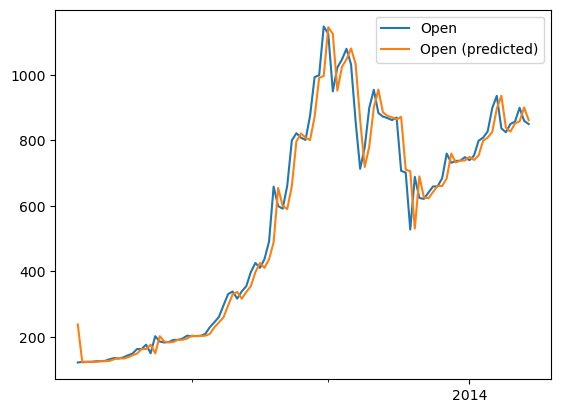

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

# format the ticks
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

dates = np.array(df["Date"]).astype(np.datetime64)

plt.plot(dates[-100:], df["Open"][-100:], label="Open")
plt.plot(dates[-100:], df["Open_predicted"][-100:], label="Open (predicted)")

plt.legend()

plt.show()